# Машинное обучение, DS-поток
## Задание ML.6


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 60 баллов;
* Задача 2 &mdash; 120 баллов;
* Задача 3 &mdash; 20 баллов + бонусы до 30 баллов.

In [1]:
# Bot check

# HW_ID: ds_ml6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.base import clone
from IPython.display import clear_output
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix

import catboost as cb
from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from tqdm import tqdm

sns.set(font_scale=1.3, palette='Set2')

---
### Задача 1

В модели XGBoost запишите задачу оптимизации при построении нового дерева, критерий информативности и оптимальные ответы в листьях в следующих случаях.
1. Задача регрессии, квадратичная функция потерь $L(y, z) = (y - z)^2$.
2. Задача классификации, экспоненциальная функция потерь $L(y, z) = e^{-yz}$.
3. Задача классификации, логистическая функция потерь $L(y, z) = \ln(1 + e^{-yz})$.

В задачах классификации классификатор предсказывает степень уверенности принадлежности классу из $\mathscr{Y} \in \{-1, +1\}$. Решающее правило имеет вид $f(x) = \mathrm{sign} \widehat{y}(x)$.

С лекции, задача оптимизации при построении новой базовой модели $b$ на шаге $t$ выглядит так:
$$\sum_{i=1}^n \left( \widetilde g_i b(x_i) + \frac{1}{2} \widetilde h_i b^2(x_i)\right) + \mu l + \frac{\lambda}{2} \sum_{k=1}^l \gamma_k^2 \rightarrow \min_b$$

Где введены обозначения:
$$\widetilde g_i = \nabla_{\hat y_{t - 1}(x_i)} \mathcal L(Y_i, \hat y_{t - 1}(x_i))$$

$$\widetilde h_i = \nabla_{\hat y_{t - 1}(x_i)}^2 \mathcal L(Y_i, \hat y_{t - 1}(x_i))$$

$l$ - число листьев

$\gamma_k$ - значение в листьях

$l$, $\lambda$ - гиперпараметры регуляризации

Критерий информативности:
$$H(X_k) = -\frac{1}{2} \frac{G_k^2}{H_k + \lambda} + \mu$$
где

$R_k$ - $k$-я область разбиения (объединение $R_k$ по $k$ дает $X$)

$$G_k = \sum_{i \in R_k} \widetilde g_i \qquad H_k = \sum_{i \in R_k} \widetilde h_i$$


Оптимальный ответ в листе:
$$\gamma_k^* = \frac{-G_k}{H_k + \lambda}$$

1) Задача регрессии + квадратичная функция потерь $L(a, b) = (b-a)^2$:
   $$\widetilde g_i = 2(\hat y_{t - 1}(x_i) - Y_i)$$
   $$\widetilde h_i = 2$$
   $$G_k = \sum_{i \in R_k} \widetilde g_i \qquad H_k = \sum_{i \in R_k} \widetilde h_i$$

   Задача оптимизации:
   $$\sum_{i=1}^n \left( 2(\hat y_{t - 1}(x_i) - Y_i) b(x_i) + b^2(x_i)\right) + \mu l + \frac{\lambda}{2} \sum_{k=1}^l \gamma_k^2 \rightarrow \min_b$$
   Критерий информативности:
   $$H(X_k) = -\frac{1}{2} \frac{\left( \sum_{i \in R_k} 2(\hat y_{t - 1}(x_i) - Y_i) \right)^2}{2 |R_k|  + \lambda} + \mu$$
   Оптимальный ответ в листе:
   $$\gamma_k^* = \frac{-\sum_{i \in R_k} 2(\hat y_{t - 1}(x_i) - Y_i)}{2|R_k| + \lambda}$$


2) Задача классификации, экспоненциальная функция потерь $L(a, b) = \exp(-ab)$
   $$\widetilde g_i = -Y_i \exp(-Y_i \hat y_{t - 1}(x_i))$$
   $$\widetilde h_i = Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i))$$
   $$G_k = \sum_{i \in R_k} \widetilde g_i \qquad H_k = \sum_{i \in R_k} \widetilde h_i$$

   Задача оптимизации:
   $$\sum_{i=1}^n \left( -Y_i \exp(-Y_i \hat y_{t - 1}(x_i)) b(x_i) + \frac{1}{2} Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i)) b^2(x_i)\right) + \mu l + \frac{\lambda}{2} \sum_{k=1}^l \gamma_k^2 \rightarrow \min_b$$
   Критерий информативности:
   $$H(X_k) = -\frac{1}{2} \frac{\left( \sum_{i \in R_k} -Y_i \exp(-Y_i \hat y_{t - 1}(x_i)) \right)^2}{\sum_{i \in R_k} \left( Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i)) \right)  + \lambda} + \mu$$
   Оптимальный ответ в листе:
   $$\gamma_k^* = \frac{\sum_{i \in R_k} Y_i \exp(-Y_i \hat y_{t - 1}(x_i))}{\sum_{i \in R_k} \left( Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i)) \right)  + \lambda}$$

2) Задача классификации, логистическая функция потерь $L(a,b) = \ln(1+\exp(-ab))$
   $$\widetilde g_i = \frac{-Y_i \exp(-Y_i \hat y_{t - 1}(x_i))}{1 + \exp(-Y_i \hat y_{t - 1}(x_i))}$$
   $$\widetilde h_i = \frac{Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i))}{\left( 1 + \exp(-Y_i \hat y_{t - 1}(x_i)) \right)^2}$$
   $$G_k = \sum_{i \in R_k} \widetilde g_i \qquad H_k = \sum_{i \in R_k} \widetilde h_i$$

   Задача оптимизации:
   $$\sum_{i=1}^n \left( \frac{-Y_i \exp(-Y_i \hat y_{t - 1}(x_i))}{1 + \exp(-Y_i \hat y_{t - 1}(x_i))} b(x_i) + \frac{1}{2} \frac{Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i))}{\left( 1 + \exp(-Y_i \hat y_{t - 1}(x_i)) \right)^2} b^2(x_i)\right) + \mu l + \frac{\lambda}{2} \sum_{k=1}^l \gamma_k^2 \rightarrow \min_b$$
   Критерий информативности:
   $$H(X_k) = -\frac{1}{2} \frac{\left( \sum_{i \in R_k} \frac{-Y_i \exp(-Y_i \hat y_{t - 1}(x_i))}{1 + \exp(-Y_i \hat y_{t - 1}(x_i))} \right)^2}{\sum_{i \in R_k} \left( \frac{Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i))}{\left( 1 + \exp(-Y_i \hat y_{t - 1}(x_i)) \right)^2} \right)  + \lambda} + \mu$$
   Оптимальный ответ в листе:
   $$\gamma_k^* = \frac{\sum_{i \in R_k} \frac{Y_i \exp(-Y_i \hat y_{t - 1}(x_i))}{1 + \exp(-Y_i \hat y_{t - 1}(x_i))}}{\sum_{i \in R_k} \left( \frac{Y_i^2 \exp(-Y_i \hat y_{t - 1}(x_i))}{\left( 1 + \exp(-Y_i \hat y_{t - 1}(x_i)) \right)^2} \right)  + \lambda}$$

---
### Задача 2

В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

Данные имеют следующие столбцы:
* `id` — идентификационный номер жилья
* `date` — дата продажи дома
* `price` — цена
* `bedrooms` — количество спален
* `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* `sqft_living` — площадь жилья
* `sqft_lot` — площадь участка
* `floors` — количество этажей
* `waterfront` — видна ли набережная
* `view` — насколько хороший вид
* `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
* `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
* `sqft_above` — жилая площадь над уровнем земли
* `sqft_basement` — жилая площадь под уровнем земли
* `yr_built` — год постройки жилья
* `yr_renovated` — год последней реконструкции жилья
* `zipcode` — почтовый индекс
* `lat` — широта
* `long` — долгота
* `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
* `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

В следующей задаче вы будете работать с ними в рамках Kaggle-соревнования. Предлагаем сначала подготовиться к нему, исследовав работу различных бустинг-библиотек применительно к этим данных. Результаты этой задаче вы сможете использовать в качестве начального решения соревнования.

**1.** Исследуйте зависимость качества по метрике MAPE для моделей 
* XGBoost, 
* LightGBM, 
* CatBoost, 
* а так же градиентного бустинга из sklearn, 

в зависимости от
* количества деревьев, 
* их максимальной глубины, 
* шага обучения, 
* $\ell_1$ и $\ell_2$ регуляризаций. 

При исследовании одного гиперпараметра рисуйте один график для всех моделей. Тщательно подберите цвета и тип линий, масштаб осей так, чтобы картинка была легко читаемой. При проведении исследований не забывайте писать подробные комментариии и выводы.

*Советы.*
* Используйте код с семинаров.
* Пока мы не умеем работать с признаком `zipcode`, удалите его из данных.

*Замечания.*
* Не забывайте, что для некоторых параметров стоит генерировать сетку значений при помощи `np.logspace`.

In [3]:
data = pd.read_csv("houses_train.csv")
data.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0   3392  20151013T000000  221900.0         3       1.00         1180   
1  18295  20151209T000000  538000.0         3       2.25         2570   
2  14569  20151209T000000  604000.0         4       3.00         1960   
3  14081  20160218T000000  510000.0         3       2.00         1680   
4   6725  20150627T000000  257500.0         3       2.25         1715   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2      5000     1.0           0     0  ...      7        1050            910   
3      8080     1.0           0     0  ...      8        1680              0   
4      6819     2.0           0     0  ...      7        1715              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1965             0    98136  47.5208 -122.393           1360   
3      1987             0    98074  47.6168 -122.045           1800   
4      1995             0    98003  47.3097 -122.327           2238   

   sqft_lot15  
0        5650  
1        7639  
2        5000  
3        7503  
4        6819  

[5 rows x 21 columns]

Вместо даты будем писать отдельно год, месяц и день; выкинем zipcode

In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%dT%H%M%S')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data.drop(['zipcode', 'date'], axis=1, inplace=True)

Разобьем на тестовые и обучающие данные:

In [5]:
X, y = data.drop(['price'], axis=1, inplace=False), data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, test_size=0.2, 
    shuffle=True, random_state=17
)

Функции для построения графиков

In [6]:
def plot_dependence_test(param_grid, test_values_list, param_label, metrics_label,
                         title, model_names, log_scale=False):
    '''
    Функция для построения графиков зависимости метрики от параметра 
    для нескольких моделей на одном графике.

    Параметры:
    1) param_grid — значения исследуемого параметра,
    2) test_values_list — список значений метрик для каждой модели,
    3) param_label — название параметра,
    4) metrics_label — название метрики,
    5) title — заголовок для графика,
    6) model_names — список названий моделей для легенды
    7) log_scale — включить ли логарифмическую шкалу по оси x
    '''
    plt.figure(figsize=(12, 6))
    
    for test_values, name in zip(test_values_list, model_names):
        plt.plot(param_grid, test_values, label=name, linewidth=2)

    if log_scale:
        plt.xscale('log')
        
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.legend()
    plt.title(title)
    plt.show()

def train_and_plot_dependence(model, X_train, y_train,
                              X_test, y_test, param_name='n_estimators',
                              max_iter=400):
    '''
    Обучает модель и собирает значения метрики для каждого этапа обучения.

    Параметры:
    1) model — модель для обучения,
    2) X_train, y_train — обучающая выборка,
    3) X_test, y_test — тестовая выборка,
    4) param_name — имя параметра модели (например, n_estimators)
    4) max_iter - задает отрезок, в котором меняется параметр [1, max_iter]
    
    Возвращает сетку значений параметра и метрику на каждом шаге (MAPE).
    '''
    model.fit(X_train, y_train)
    if hasattr(model, 'staged_predict'):
        predictions = np.array(list(model.staged_predict(X_test)))
    else:
        predictions = []
        model.set_params(n_estimators=1)

        for i in range(1, max_iter + 1):
            model_clone = clone(model)
            model_clone.n_estimators = i 
            model.n_estimators = i
            model_clone.fit(X_train, y_train)
            pred = model_clone.predict(X_test)
            predictions.append(pred)
            
    test_values = []
    for p in predictions:
        test_values.append(mape(y_test, p))
    param_grid = np.arange(1, len(test_values) + 1)
    
    return param_grid, test_values

Обучаем модели:

In [7]:
models = [
    GradientBoostingRegressor(n_estimators=400),
    xgb.XGBRegressor(n_estimators=400),
    LGBMRegressor(n_estimators=400),
    CatBoostRegressor(n_estimators=400)
]

model_names = ['Sklearn', 'XGB', 'LGBM', 'CatBoost']

test_values_list = []
param_grid = None

for model in models:
    param_grid, test_values = train_and_plot_dependence(
        model, X_train, y_train, X_test, y_test
    )
    test_values_list.append(test_values)
    clear_output()

И сами графики

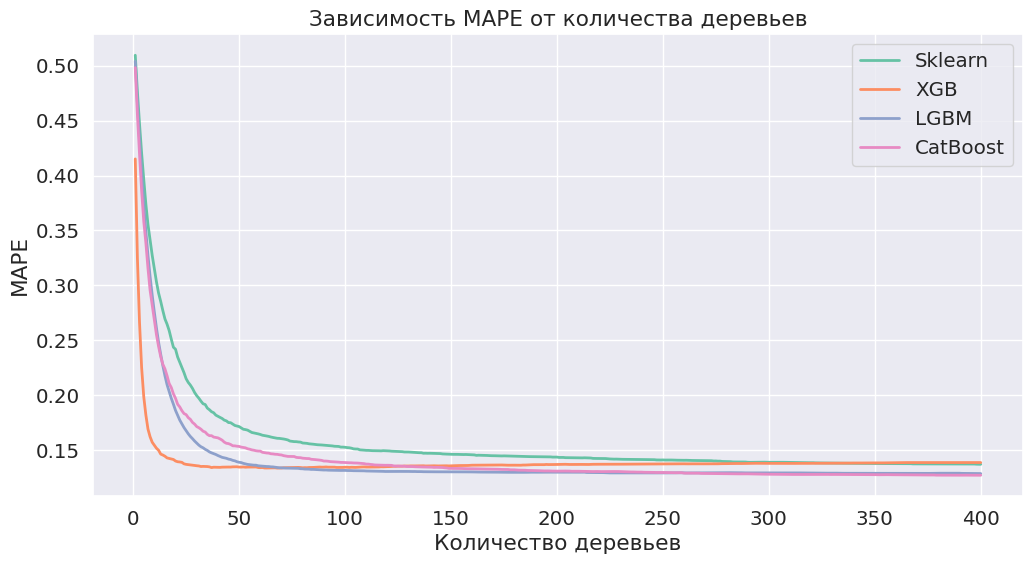

In [8]:
plot_dependence_test(param_grid, test_values_list, 
                     'Количество деревьев', 'MAPE', 
                     'Зависимость MAPE от количества деревьев', model_names)

Теперь построение графиков для более общего случая параметров:

In [9]:
def train_and_plot_dependence(model, X_train, y_train,
                              X_test, y_test, param_name='n_estimators',
                              param_grid=None):
    '''
    Обучает модель и собирает значения метрики для каждого этапа обучения.

    Параметры:
    1) model — модель для обучения,
    2) X_train, y_train — обучающая выборка,
    3) X_test, y_test — тестовая выборка,
    4) param_name — имя параметра модели (например, n_estimators)
    5) param_grid — значения для изменения параметра модели (например, [1, 2, 3, ...])
    
    Возвращает сетку значений параметра и метрику на каждом шаге (MAPE).
    '''
    
    predictions = []
    
    for param_value in param_grid:
        model_clone = clone(model)
        model_clone.set_params(**{param_name: param_value})
        model_clone.fit(X_train, y_train)
        pred = model_clone.predict(X_test)
        predictions.append(pred)
            
    test_values = [mape(y_test, p) for p in predictions]

    return param_grid, test_values

Сами данные:

In [10]:
models = [
    GradientBoostingRegressor(),
    XGBRegressor(),
    LGBMRegressor(verbose=-1),
    CatBoostRegressor(silent=True)
]
l1_models = [
    XGBRegressor(),
    LGBMRegressor(verbose=-1),
]
l2_models = [
    XGBRegressor(),
    LGBMRegressor(verbose=-1),
    CatBoostRegressor(silent=True)
]

model_names = ['Sklearn', 'XGB', 'LGBM', 'CatBoost']
l1_model_names = ['XGB', 'LGBM']
l2_model_names = ['XGB', 'LGBM', 'CatBoost']

max_depth_grid = np.arange(1, 15)
max_depth_mape = []

for model in tqdm(models):
    param_grid, test_values = train_and_plot_dependence(
        model, X_train, y_train, X_test, y_test,
        param_name='max_depth', param_grid=max_depth_grid
    )
    max_depth_mape.append(test_values)
    clear_output()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [09:14<00:00, 138.65s/it]


Для шага обучения

In [11]:
learning_rate_grid = np.logspace(-3, 0, num=15) 
learning_rate_mape = []

for model in tqdm(models):
    param_grid, test_values = train_and_plot_dependence(
        model, X_train, y_train, X_test, y_test,
        param_name='learning_rate', param_grid=learning_rate_grid
    )
    learning_rate_mape.append(test_values)
    clear_output()

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:36<00:00, 24.16s/it]


Для регуляризации

In [13]:
reg_grid = np.logspace(-13, 5, num=20) 
l1_mape = []
l2_mape = []

for model in tqdm(l1_models):
    param_name = 'reg_alpha'
    param_grid, test_values = train_and_plot_dependence(
        model, X_train, y_train, X_test, y_test,
        param_name=param_name, param_grid=reg_grid
    )
    l1_mape.append(test_values)

for model in tqdm(l2_models):
    param_name = 'reg_lambda' if not isinstance(model, CatBoostRegressor) else 'l2_leaf_reg'
    param_grid, test_values = train_and_plot_dependence(
        model, X_train, y_train, X_test, y_test,
        param_name=param_name, param_grid=reg_grid
    )
    l2_mape.append(test_values)
    clear_output()

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.32s/it]


И построение графиков

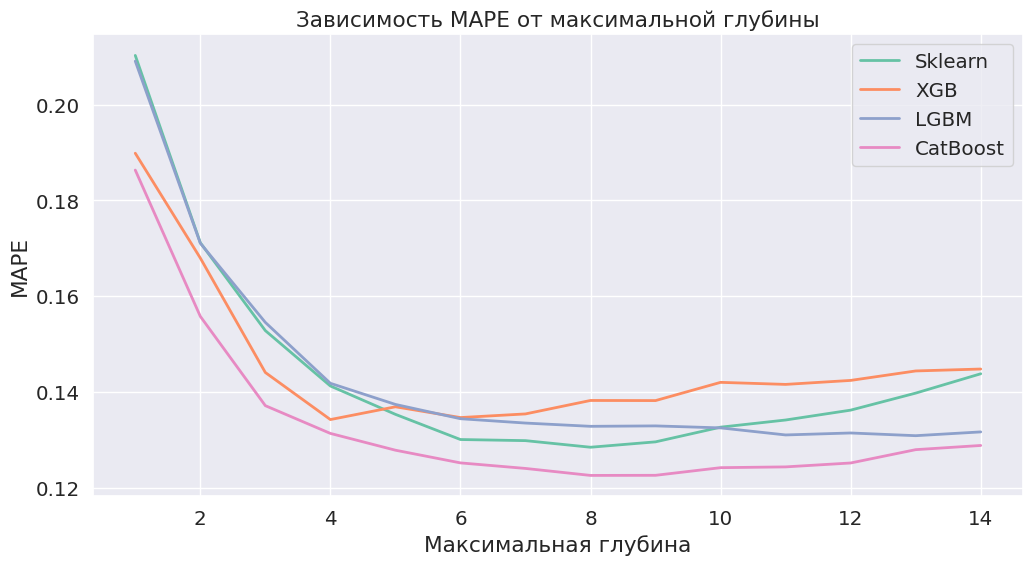

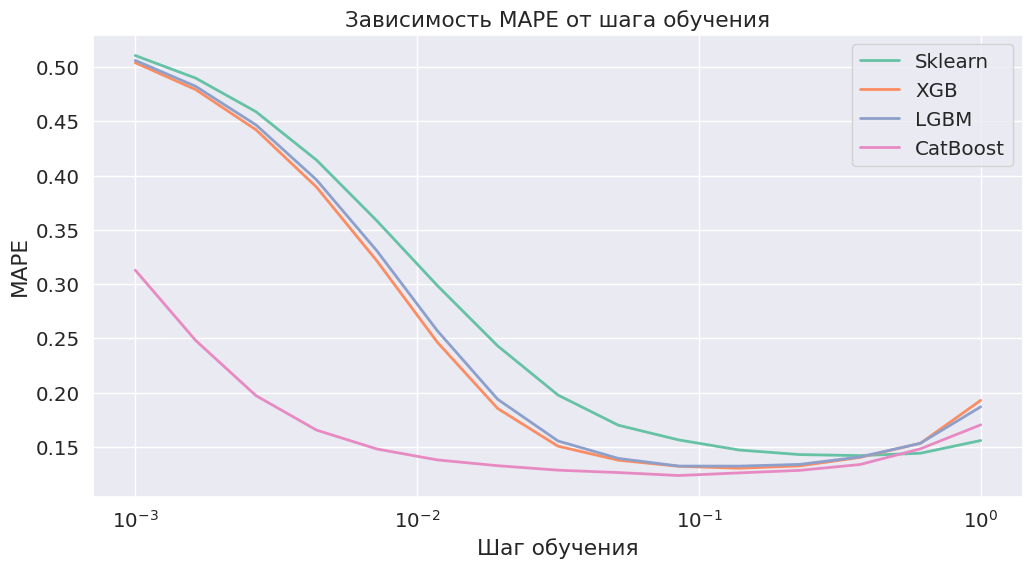

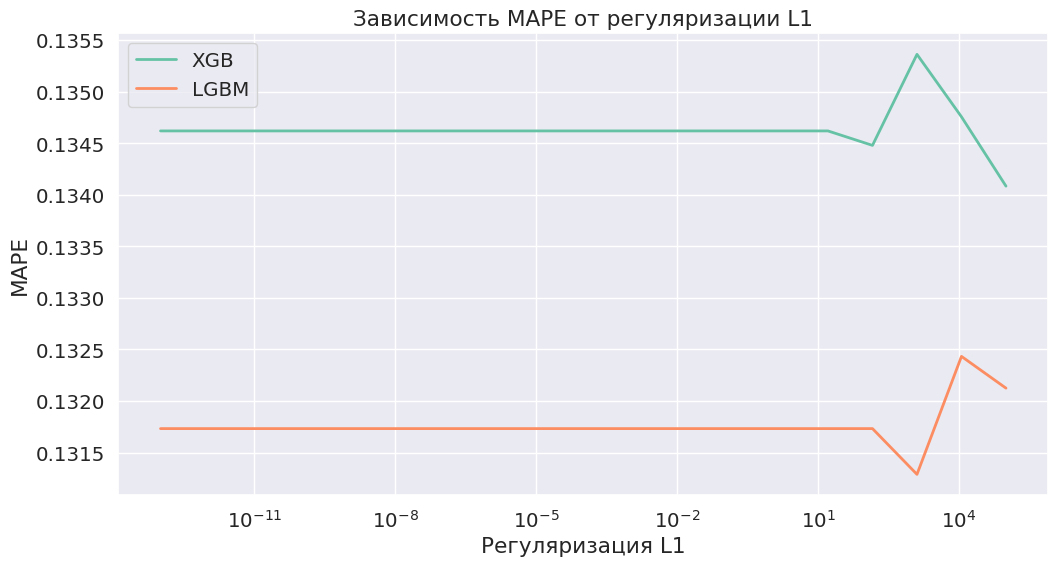

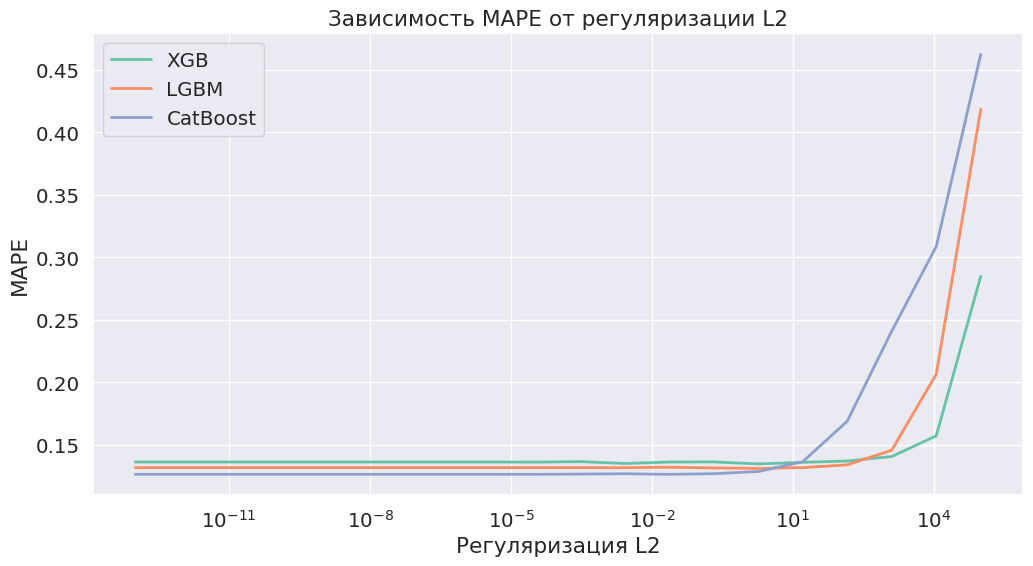

In [14]:
plot_dependence_test(max_depth_grid, max_depth_mape, 
                     'Максимальная глубина', 'MAPE', 
                     'Зависимость MAPE от максимальной глубины', model_names)
plot_dependence_test(learning_rate_grid, learning_rate_mape, 
                     'Шаг обучения', 'MAPE', 
                     'Зависимость MAPE от шага обучения',
                     model_names, log_scale=True)
plot_dependence_test(reg_grid, l1_mape, 
                     'Регуляризация L1', 'MAPE', 
                     'Зависимость MAPE от регуляризации L1',
                     l1_model_names, log_scale=True)
plot_dependence_test(reg_grid, l2_mape, 
                     'Регуляризация L2', 'MAPE', 
                     'Зависимость MAPE от регуляризации L2',
                     l2_model_names, log_scale=True)

**Вывод:**

1) Оптимальная максимальная глубина 4-8, далее наблюдается переобучение (XGB более склонно к переобучению, дале Sklearn, затем Catboost)

2) При маленьком lr не успевают обучаться модели (в сильно меньшей степени CatBoost), при более высоких переобучение, оптимально нужно варьировать окло 10^-1

3) Регуляризация не помогает в задаче (ни l1, ни l2) - когда она начинает играть роль, MAPE растет

**2.** Нарисуйте по несколько деревьев каждой из моделей с помощью функций `plot_tree`, которая реализована в каждой из библиотек. Для этого потребуется немного разобраться с тем, как работают эти функции. 

Какие особенности можно заметить? Как меняются деревья при изменении максимальной глубины? Что выдает CatBoost в листе, если в него не попали объекты обучающей выборки?

Импорты

In [15]:
from sklearn.tree import plot_tree
from catboost import Pool

Для модели из Sklearn:

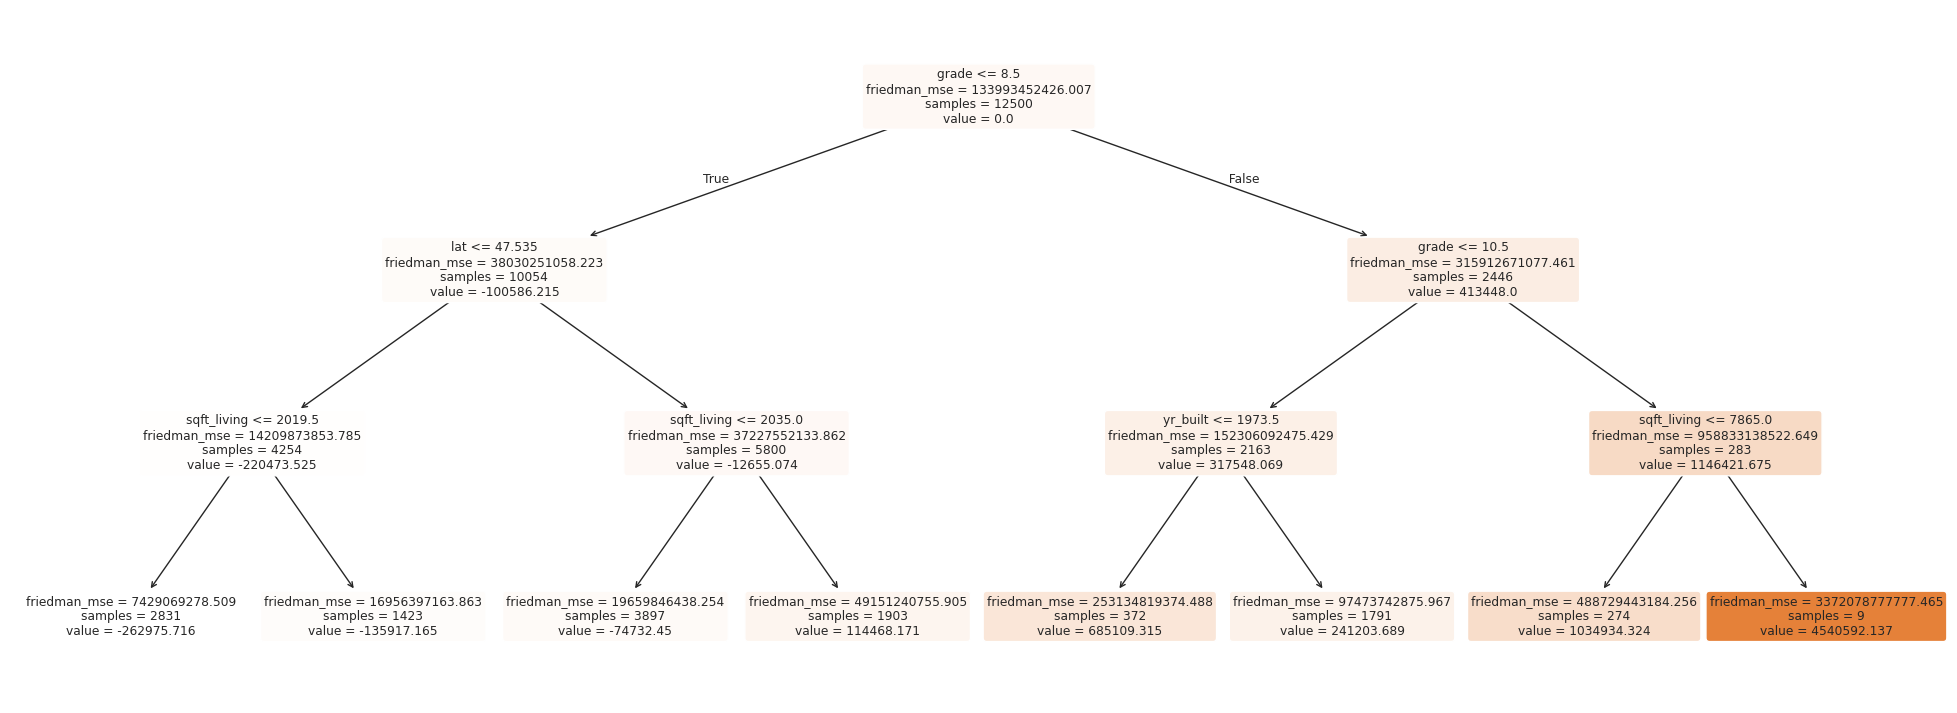

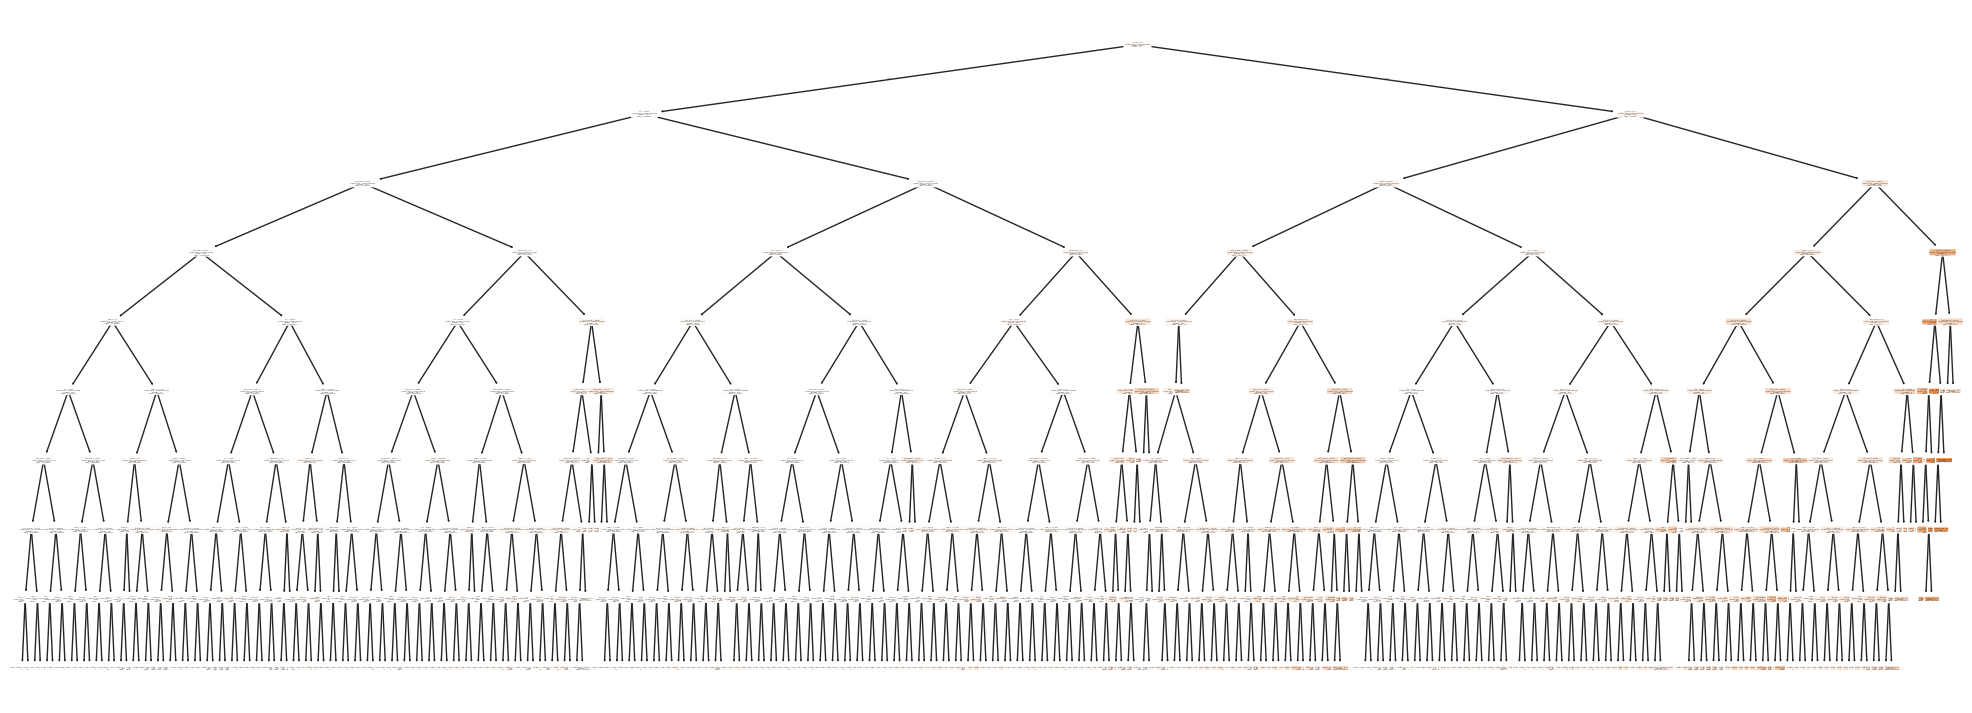

In [16]:
gb = GradientBoostingRegressor(max_depth=3)
gb.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 9))
plot_tree(gb.estimators_[0, 0], ax=ax, filled=True,
          rounded=True, feature_names=X_train.columns)

plt.show()

gb = GradientBoostingRegressor(max_depth=9)
gb.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 9))
plot_tree(gb.estimators_[0, 0], ax=ax, filled=True,
          rounded=True, feature_names=X_train.columns)

plt.show()

Для XGB:

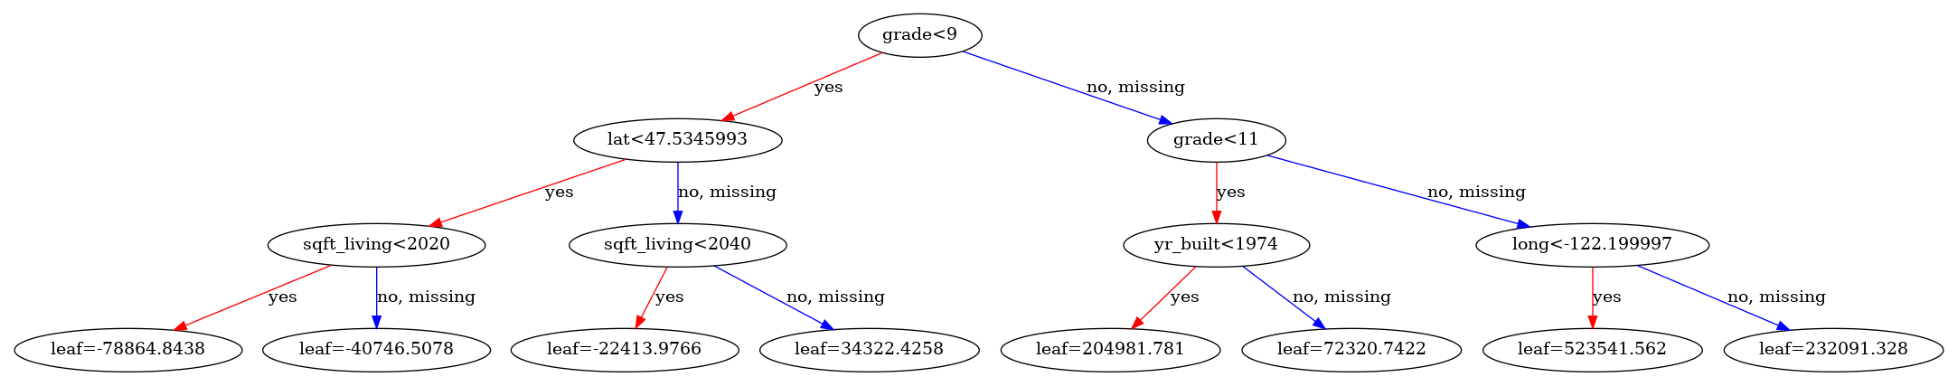

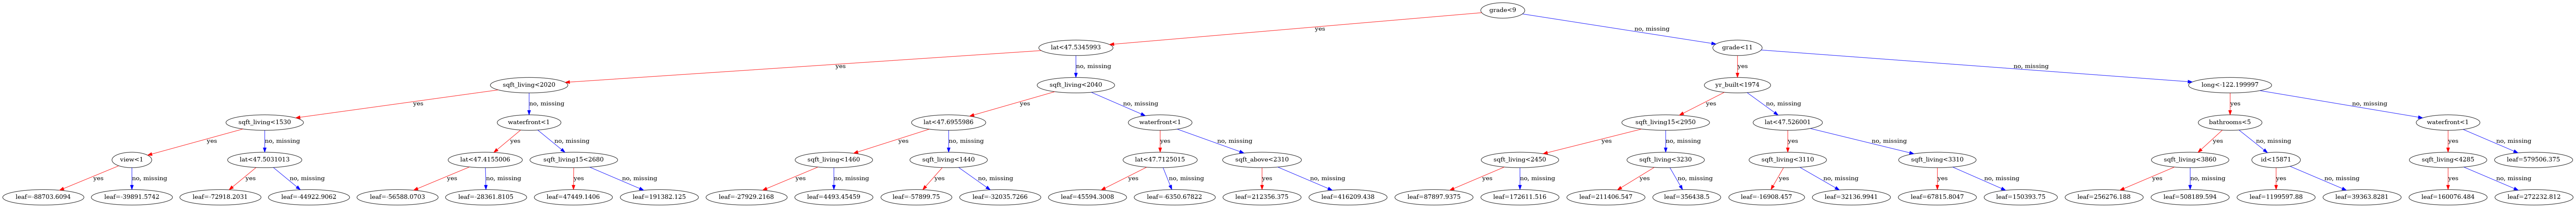

In [17]:
model = XGBRegressor(max_depth=3)
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 9))
xgb.plot_tree(model, num_trees=0, ax=ax)

plt.show()

model = XGBRegressor(max_depth=5)
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(300, 300))
xgb.plot_tree(model, num_trees=0, ax=ax)

plt.show()

Для LGBM

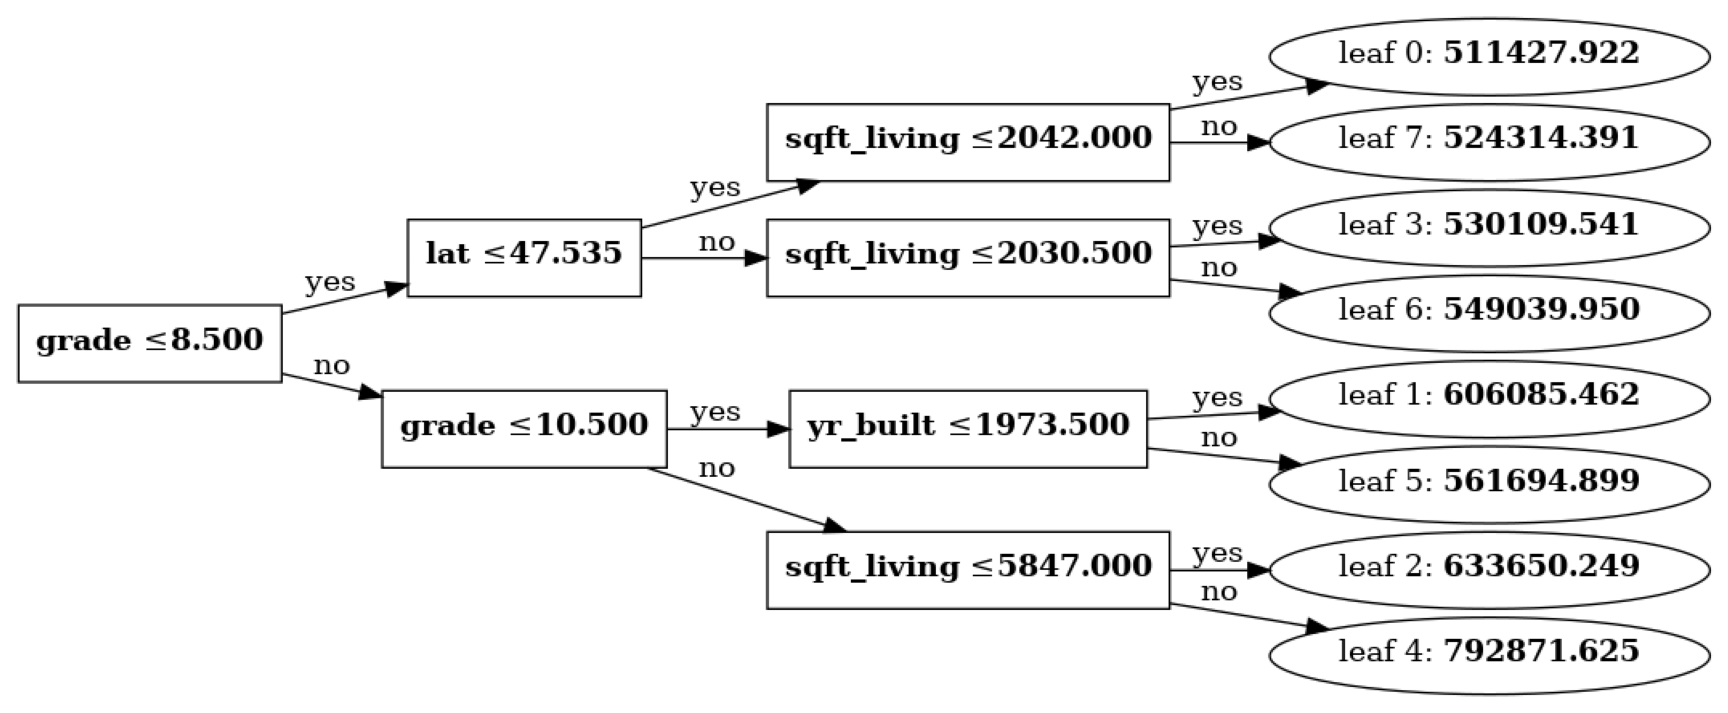

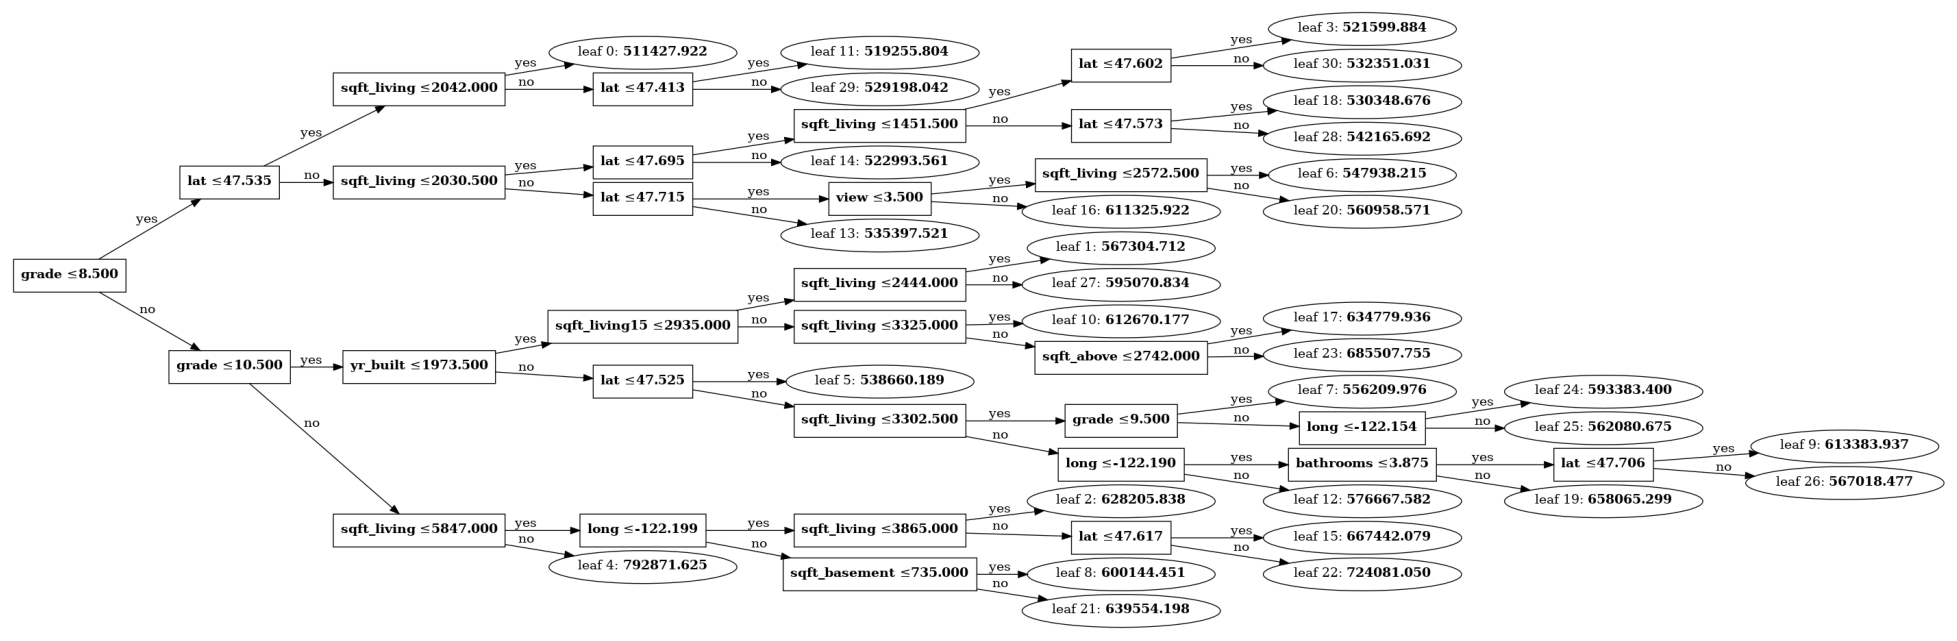

In [18]:
model = LGBMRegressor(max_depth=3, verbose=-1)
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 9))
lgb.plot_tree(model, ax=ax)

plt.show()

model = LGBMRegressor(max_depth=9, verbose=-1)
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 9))
lgb.plot_tree(model, ax=ax)

plt.show()

Для CatBoost

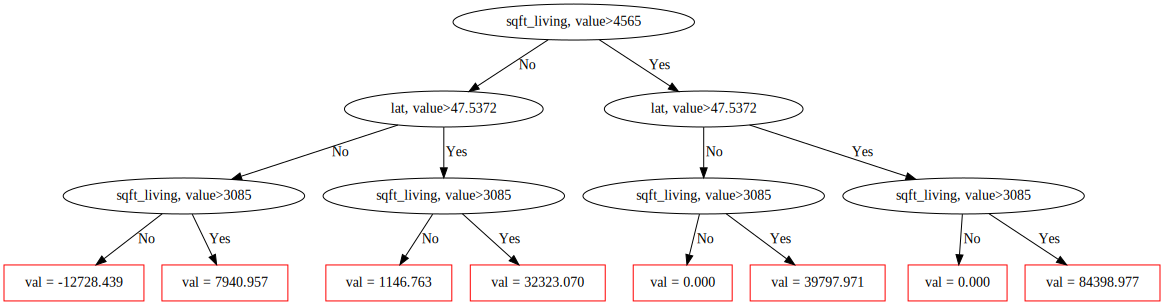

In [19]:
model = CatBoostRegressor(max_depth=3, silent=True)
model.fit(X_train, y_train)
pool = Pool(X_train, y_train)
model.plot_tree(tree_idx=0, pool=pool)


In [20]:
model = CatBoostRegressor(max_depth=9, silent=True)
model.fit(X_train, y_train)
pool = Pool(X_train, y_train)
model.plot_tree(tree_idx=0, pool=pool)

**Выводы:**

1) Деревья растут везде до максимальной глубины да таких глубинах, кроме LGBM, который начиная с некоторого значения скорее идет вдоль только некотоорых ветвей
2) Catboost ставит в лист 0, если туда не попали значения
3) Самые значимые признаки - sqft_living, lat - по ним в основном разбиения и происходят во всех деревьях

**3.** Исследуйте среднее время обучения и предсказания для разных моделей. Для более честного сравнения для каждой модели стоит использовать те значения гиперпараметров, которые для нее оптимальны.

Подбор параметров для Sklearn:

In [21]:
param_grid = {
    'max_depth': np.arange(2, 11), 
    'learning_rate': np.logspace(-2, 0, num=25),
    'n_estimators': np.arange(50, 500, 50),
    #'init__alpha': np.logspace(-13, -5, num=3),
}

gb_gridsearch = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(), 
    param_distributions=param_grid,
    scoring='neg_mean_absolute_percentage_error',  # оптимизируемый скор
    cv=3,  # разбиение выборки на 5 фолдов
    verbose=7,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=30,  # кол-во итераций случайного выбора гиперпараметров
)
gb_gridsearch.fit(X_train, y_train)
clear_output()

Для XGB:

In [22]:
param_grid = {
    'max_depth': np.arange(2, 11), 
    'learning_rate': np.logspace(-2, 0, num=25),
    'n_estimators': np.arange(50, 500, 50),
    ## Параметр для регуляризации из соображений про графики
    'reg_alpha': [1e-13],
    'reg_lamda': [1e-13],
}

xgb_gridsearch = RandomizedSearchCV(
    estimator=XGBRegressor(), 
    param_distributions=param_grid,
    scoring='neg_mean_absolute_percentage_error',  # оптимизируемый скор
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=7,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=90,  # кол-во итераций случайного выбора гиперпараметров
)
xgb_gridsearch.fit(X_train, y_train)
clear_output()

Для LGB:

In [25]:
param_grid = {
    'max_depth': np.arange(2, 11), 
    'learning_rate': np.logspace(-2, 0, num=25),
    'n_estimators': np.arange(50, 500, 50),
    ## Параметр для регуляризации из соображений про графики
    'reg_alpha': [1e-13],
    'reg_lamda': [1e-13],
}

lgb_gridsearch = RandomizedSearchCV(
    estimator=LGBMRegressor(verbose=-1), 
    param_distributions=param_grid,
    scoring='neg_mean_absolute_percentage_error',  # оптимизируемый скор
    cv=3,  # разбиение выборки на 5 фолдов
    verbose=7,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=90,  # кол-во итераций случайного выбора гиперпараметров
)
lgb_gridsearch.fit(X_train, y_train)
clear_output()

Для Catboost:

In [26]:
param_grid = {
    'max_depth': np.arange(2, 11), 
    'learning_rate': np.logspace(-2, 0, num=25),
    'n_estimators': np.arange(50, 500, 50),
    ## Параметр для регуляризации из соображений про графики
    'l2_leaf_reg': [1e-13],
}

cb_gridsearch = RandomizedSearchCV(
    estimator=CatBoostRegressor(silent=True), 
    param_distributions=param_grid,
    scoring='neg_mean_absolute_percentage_error',  # оптимизируемый скор
    cv=3,  # разбиение выборки на 5 фолдов
    verbose=7,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=90,  # кол-во итераций случайного выбора гиперпараметров
)
cb_gridsearch.fit(X_train, y_train)
clear_output()

Лучшие параметры:

In [27]:
def round_params(gridsearch, precision=1):
    """Выводит лучшие параметры для модели из GridSearchCV"""
    list_keys = list(gridsearch.best_params_.keys())
    print("Лучшие параметры:")

    for key in list_keys:
        if isinstance(gridsearch.best_params_[key], (int, float)):
            value = round(gridsearch.best_params_[key], precision)
        else:
            value = gridsearch.best_params_[key]
        print(f"{key:<{15}}: {value}")

# Вывод лучших параметров для каждой модели
print("Лучшие параметры для Gradient Boosting:")
round_params(gb_gridsearch, 2)
print("\nЛучшие параметры для XGBoost:")
round_params(xgb_gridsearch, 2)
print("\nЛучшие параметры для LightGBM:")
round_params(lgb_gridsearch, 2)
print("\nЛучшие параметры для CatBoost:")
round_params(cb_gridsearch, 2)

Лучшие параметры для Gradient Boosting:
Лучшие параметры:
n_estimators   : 250
max_depth      : 8
learning_rate  : 0.05

Лучшие параметры для XGBoost:
Лучшие параметры:
reg_lamda      : 0.0
reg_alpha      : 0.0
n_estimators   : 350
max_depth      : 7
learning_rate  : 0.07

Лучшие параметры для LightGBM:
Лучшие параметры:
reg_lamda      : 0.0
reg_alpha      : 0.0
n_estimators   : 350
max_depth      : 7
learning_rate  : 0.03

Лучшие параметры для CatBoost:
Лучшие параметры:
n_estimators   : 50
max_depth      : 7
learning_rate  : 0.38
l2_leaf_reg    : 0.0


Теперь для лучших параметров времена работы:

Функция для подсчета времен работы:

In [28]:
import time

def measure_time(model, X_train, y_train, X_test,
                 n_trials_train=2, n_trials_predict=3):
    model_clone = clone(model)
    training_times = []
    prediction_times = []

    for _ in range(n_trials_train):
        start_time = time.time()
        model_clone.fit(X_train, y_train)
        training_times.append(time.time() - start_time)

    average_training_time = np.mean(training_times) 

    for _ in range(n_trials_predict):
        start_time = time.time()
        model_clone.predict(X_test)
        prediction_times.append(time.time() - start_time)

    average_prediction_time = np.mean(prediction_times)
    
    return round(average_training_time, 2), round(average_prediction_time, 4)

Вывод времен работы:

In [29]:
results = {}

results['Gradient Boosting'] = measure_time(gb_gridsearch.best_estimator_,
                                            X_train, y_train, X_test)
results['XGBoost'] = measure_time(xgb_gridsearch.best_estimator_,
                                  X_train, y_train, X_test)
results['LightGBM'] = measure_time(lgb_gridsearch.best_estimator_,
                                   X_train, y_train, X_test)
results['CatBoost'] = measure_time(cb_gridsearch.best_estimator_,
                                   X_train, y_train, X_test)

results_df = pd.DataFrame.from_dict(results, orient='index',
                                    columns=['Время обучения (с)',
                                             'Время предсказания (s)'])
clear_output()
print(results_df)

                   Время обучения (с)  Время предсказания (s)
Gradient Boosting               18.73                  0.0274
XGBoost                          1.36                  0.0158
LightGBM                         0.43                  0.0226
CatBoost                         0.24                  0.0036


Сравнение моделей по лучшему скору:

In [30]:
best_scores = {
    'Gradient Boosting': -gb_gridsearch.best_score_,
    'XGBoost': -xgb_gridsearch.best_score_,
    'LightGBM': -lgb_gridsearch.best_score_,
    'CatBoost': -cb_gridsearch.best_score_
}

best_scores_df = pd.DataFrame.from_dict(best_scores, orient='index', columns=['Best Score'])

df = results_df.join(best_scores_df)

df

Время обучения (с)  Время предсказания (s)  Best Score
Gradient Boosting               18.73                  0.0274    0.129532
XGBoost                          1.36                  0.0158    0.126284
LightGBM                         0.43                  0.0226    0.133491
CatBoost                         0.24                  0.0036    0.137863

**Выводы:**

1) Все модели, кроме Gradient Boosting - обучаются довольно быстро, это значит, что в нет отсутсвуют дополнительные оптимизации
2) При этом CatBoost самый быстрый, LightGBM чуть быстрее, медленнее - XGBoost
3) Самые быстрые предсказания у CatBoost, чуть быстрее XGBoost, GradientBoosting и LightGBM примерно одинаково
4) Лучший скор у XGBoost

---
### Задача 3

В продолжении исследований из предыдущей задачи выберите некоторое количество хороших на ваш взгляд моделей, постройте для них предсказание на тестовой выборке. Полученные предсказания отправьте в тренировочное соревнование на Kaggle.

Ссылка: https://www.kaggle.com/competitions/ds-2024-autumn-36

Инвайт: https://www.kaggle.com/t/a58c055b57ac4a04b857ad11fe607333

**Правила**

* В Kaggle в данное тренировочное соревнование можно отправлять не более 7 решений в день (8-ю система не позволит).
* Решения индивидуальные.
* Качество считается по метрике MAPE.
* До окончания соревнования доступны значения качества, посчитанные только на случайных 30% тестовых данных. Значения отображаются в Public Leaderboard
* После окончания соревнования становится доступным Private Leaderboard, в котором значения качества посчитанны на оставшихся 70% объектов.
* Для включения в Private Leaderboard можно выбрать две посылки.
* В Leaderboard должны отображаться ваши **реальные имя и фамилия**. В противном случае решение может быть не зачтено.
* Все файлы, которые вы отправляете в соревнование, видны организаторам соревнования. Файлы должны иметь понятное имя, при отправке файла в систему необходимо написать краткое описание решения. **Это будет проверяться.**
* В решении, отправляемом боту, должно быть отображено, результаты каких моделей вы отправляете в соревнование.
* Не забывайте сделать пояснения к своему решению. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* Пользоваться можно любыми пройденными в наших курсах моделями.
* Нельзя пользоваться любыми методами и моделями, которые мы не проходили, и которых не было в ранее в иных курсах, которые обязательны для всех.
* Код студентов, занявших первые 3 места, будет запускаться. Также выборочно может запускаться код и остальных студентов.

**Сроки сдачи**
 
* **Дедлайн в Kaggle** совпадает с дедлайном по заданию. Дедлайн строгий, Kaggle не позволит сдать даже на секунду позже.
* Также **до дедлайна необходимо сдать в бот** существующий вариант решения, возможно, без пояснений.
* **До 23:59 следующих суток** необходимо дооформить решение, соответствующее наилучшему варианту по Private Leaderboard и сдать в бот по отдельной кнопке. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* В случае, если вы до основного дедлайна сдаете оформленное решение, его нужно сдать по двум кнопкам сразу &mdash; соответствующей основной сдаче, и отдельной для оформленного решения.

**Советы**

* Чтобы получить действительно хороший результат подбора гиперпараметров мало, попробуйте ввести новые признаки для улучшения качества решения.
* Некоторые инсайты по тому, какие признаки могут улучшить качество, можно получить если провести разведывательный анализ данных (EDA). Например, может иметь смысл изучить датасет на предмет наличия выбросов, исследовать пространственное и временное распределение отклика. 
* Сохраняйте код и результаты каждой модели в отдельных файлах. Добавляйте к ним понятные описания, которые помогут вам при необходимости продолжить использовать решение.

**Бонусы**

* **Выдаются только при соблюдении всех правил** и суммируются.
* 15 баллов — ваше решение лучше `sample_submission.csv` на Private Leaderboard.
* 15 баллов — ваше решение имеет ошибку не более 12.3% по метрике MAPE на Private Leaderboard.
* 1 конфета — попадание в топ-10 на Private Leaderboard.
* 1 средняя конфета — попадание в топ-3 на Private Leaderboard.
* 1 большая конфета — попадание в топ-1 на Private Leaderboard.

In [31]:
best_models = {
    'Gradient Boosting': GradientBoostingRegressor(**gb_gridsearch.best_params_),
    'XGBoost': XGBRegressor(**xgb_gridsearch.best_params_),
    'LightGBM': LGBMRegressor(**lgb_gridsearch.best_params_, verbose=-1),
    'CatBoost': CatBoostRegressor(**cb_gridsearch.best_params_, silent=True)
}


Обучающие данные:

In [32]:
full_train_data = pd.read_csv("houses_train.csv")

full_train_data['date'] = pd.to_datetime(full_train_data['date'], format='%Y%m%dT%H%M%S')
full_train_data['year'] = full_train_data['date'].dt.year
full_train_data['month'] = full_train_data['date'].dt.month
full_train_data['day'] = full_train_data['date'].dt.day
full_train_data.drop(['zipcode', 'date'], axis=1, inplace=True)
X_full_train, y_full_train = full_train_data.drop(['price'], axis=1, inplace=False), data['price']

Тестовые данные:

In [33]:
full_test_data = pd.read_csv("houses_test.csv")

full_test_data['date'] = pd.to_datetime(full_test_data['date'], format='%Y%m%dT%H%M%S')
full_test_data['year'] = full_test_data['date'].dt.year
full_test_data['month'] = full_test_data['date'].dt.month
full_test_data['day'] = full_test_data['date'].dt.day
full_test_data.drop(['zipcode', 'date'], axis=1, inplace=True)
X_full_test = full_test_data

Обучим лучшую модель из предыдущего пункта и сохраним результат

In [35]:
best_models['XGBoost'].fit(X_full_train, y_full_train)
predictions = best_models['XGBoost'].predict(X_full_test)

df = pd.DataFrame({
    'price': predictions   
})

df.index = df.index + 1

df.to_csv('ErmolaevFedor.csv', index=True, index_label='index')

/home/juequ/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:40:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "reg_lamda" } are not used.

  warnings.warn(smsg, UserWarning)
